In [123]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy import stats
from itertools import product

In [58]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', index_col = ['month'], dayfirst = True, parse_dates = ['month'])

### Визуальный анализ ряда

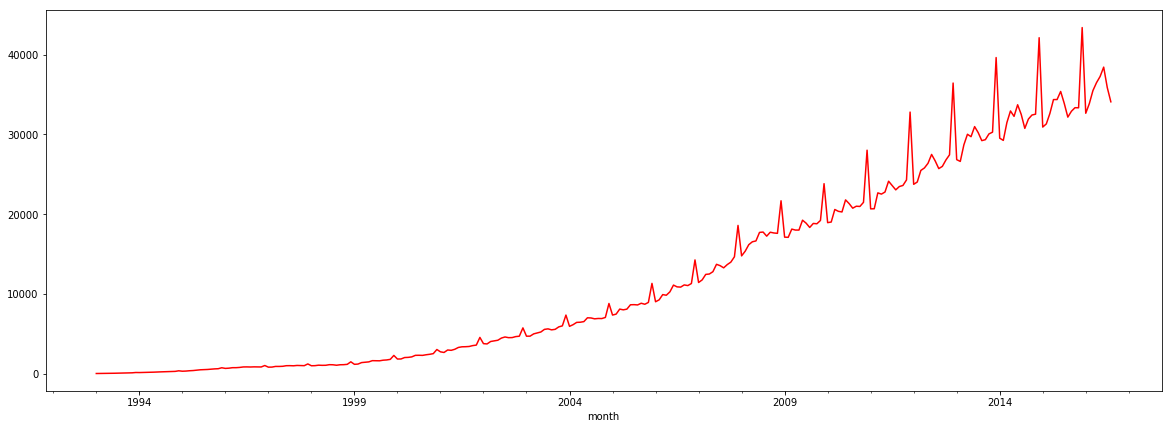

In [59]:
plt.figure(figsize=(20,7))

data.WAG_C_M.plot(color = 'r')

plt.show()

На графике виден хорошо выраженный повышающийся тренд. Кроме того, наблюдаются рост дисперсии и годовая сезонность: значение признака совершает колебания, минимум которых всегда приходится на начало года (январь), а максимум — на конец года (декабрь).

Проверка стационарности и STL-декомпозиция ряда:

<Figure size 1080x720 with 0 Axes>

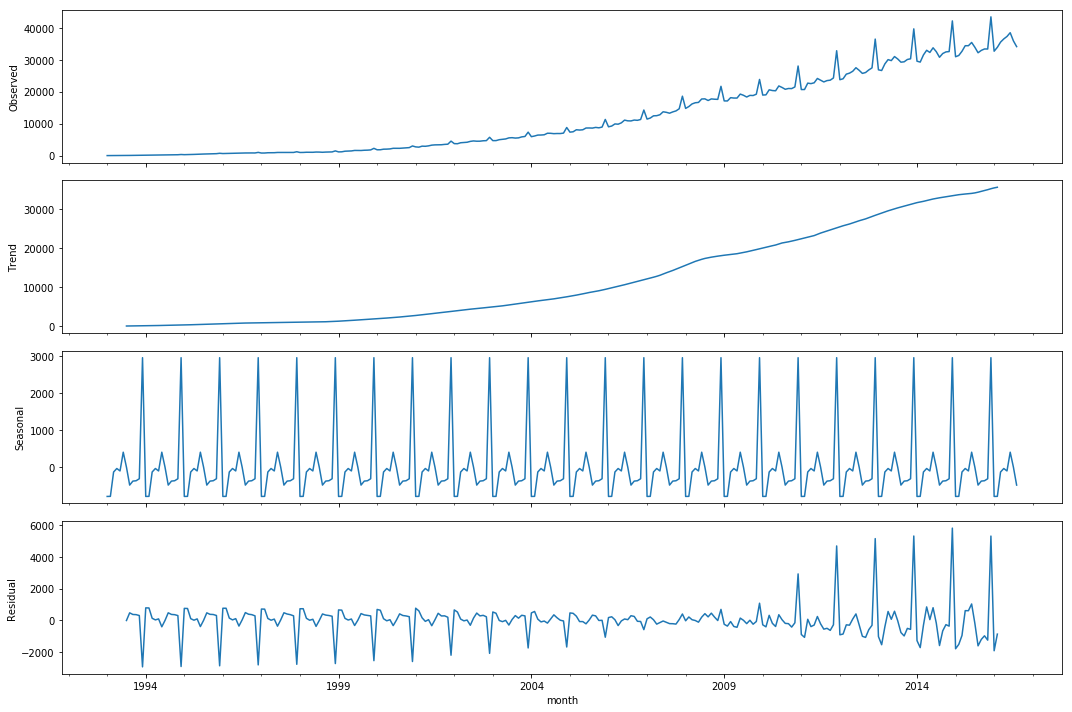

In [73]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()

Проверим гипотезу о стационарности ряда:

Критерий Дики-Фуллера

$H_0:$ ряд не стационарный

$H_1:$ ряд стационарный

In [62]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Гипотеза о не стационарности ряда уверенно принимается. Впрочем, посмотрев на графики выше, можно прийти к тому же выводу: сезонность, тренд и непостоянство дисперсии говорят о не стационарности ряда.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202


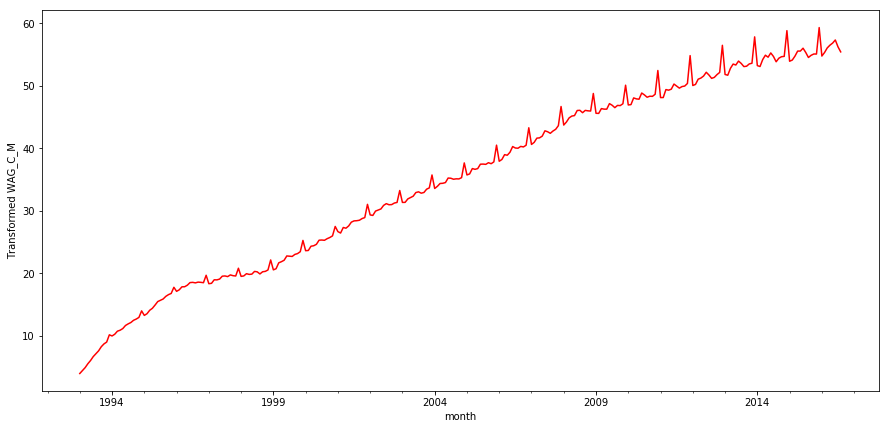

In [71]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize=(15,7))
data.WAG_C_M_box.plot(color = 'r')
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

In [67]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Критерий Дики-Фуллера: p=0.696899


Стационарность ряда по-прежнему отвергается. Проведем дифференциирование ряда для достижения стационарности.

### Выбор порядка дифференциирования

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

<Figure size 1080x720 with 0 Axes>

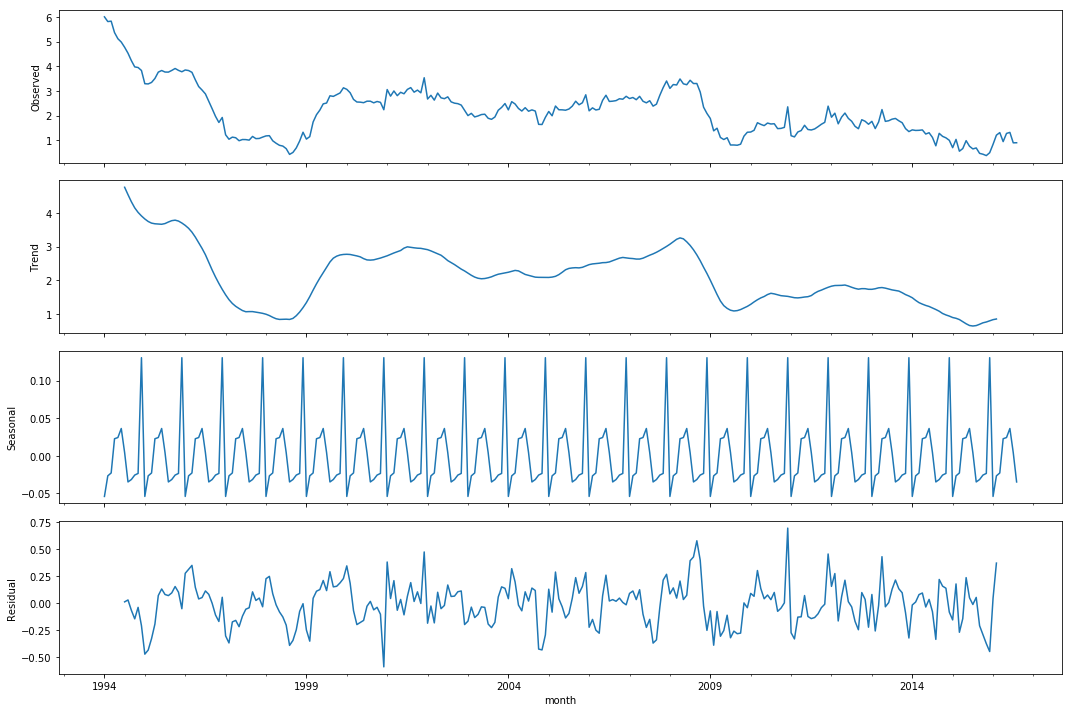

In [77]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
plt.show()

In [78]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.014697


Гипотеза о не стационарности отвергается. Но не будем доверять критерию Дики-Фуллера, на графиках наблюдается понижающийся тренд с частичными провалами. Прибегнем к еще одному обычному дифференциированию:

<Figure size 1080x720 with 0 Axes>

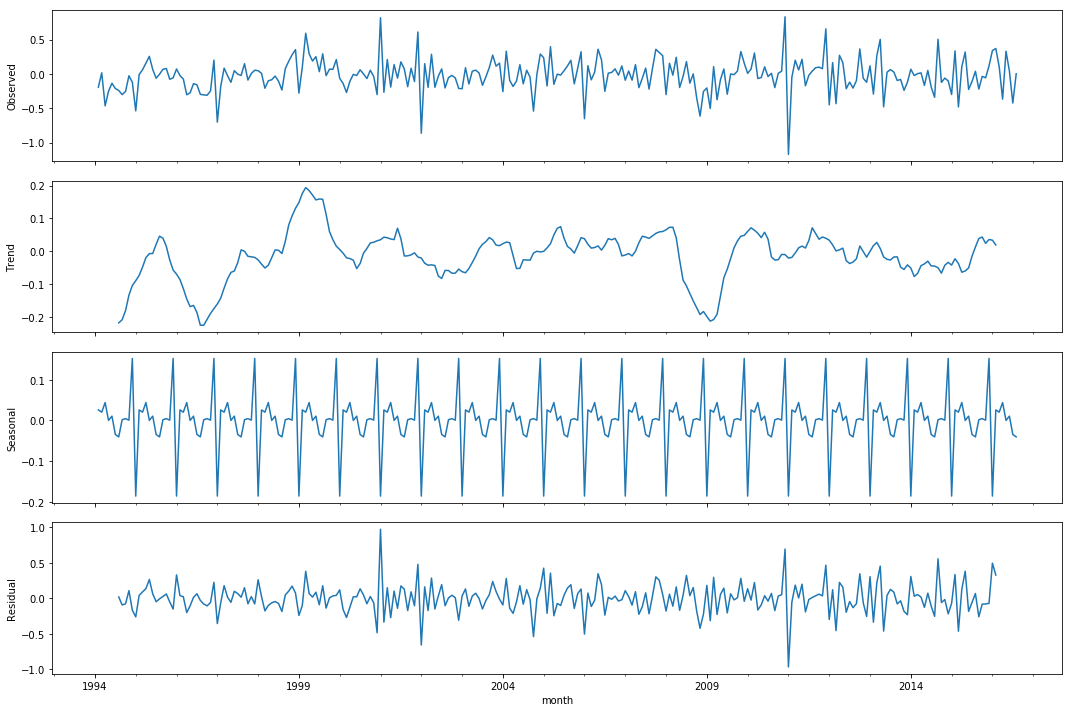

In [82]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()   
plt.show()

In [84]:
print("Критерий Дики-Фуллера: p=%.10f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.0000000520


Гипотеза о стационарности ряда уверенно принимается.

### Выбор начальных приближений для $p, q, P, Q$

Посмотрим на ACF и PACF полученного ряда:

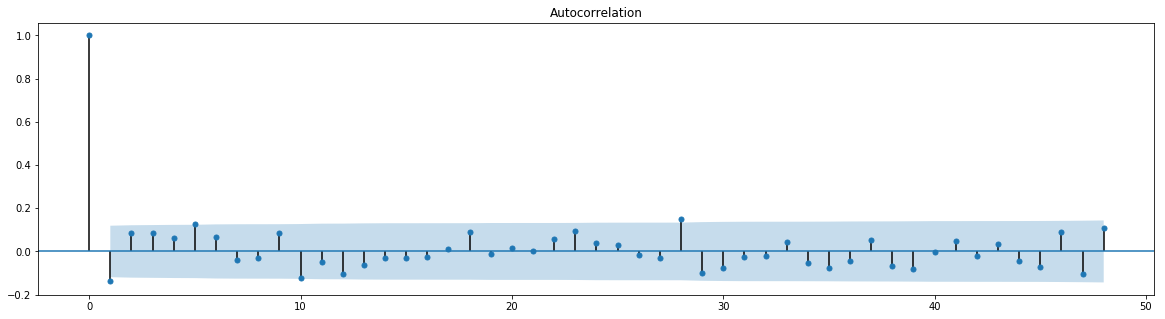

In [116]:
plt.figure(figsize=(20,5))
ax = plt.subplot()
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values, lags=48,ax=ax)
plt.show()

Начальные приближения: Q=0, так как на графике нет ни одного значимого номера сезонного лага; q=5, не будем брать большой номер лага, чтобы не усложнять модель прогнозирования.



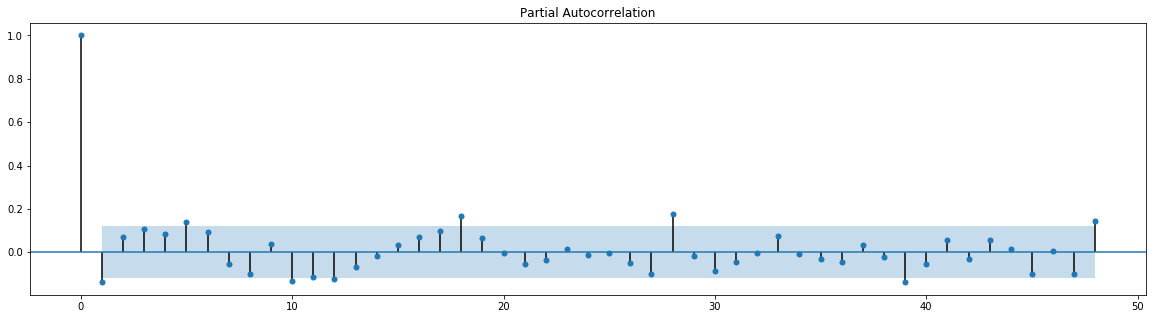

In [117]:
plt.figure(figsize=(20,5))
ax = plt.subplot()
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values, lags=48,ax=ax)
plt.show()

Начальные приближения: P=4 (лаг 48 поделить на период сезона 12мес.); p=5, не будем брать большой номер лага, чтобы не усложнять модель прогнозирования.

In [126]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = [0]

In [130]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

### Обучение и сравнение моделей-кандидатов, выбор победителя

In [132]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 2, 0))
('wrong parameters:', (4, 2, 3, 0))
('wrong parameters:', (4, 2, 4, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4,

In [133]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
131  (5, 5, 1, 0) -25.107711
116  (4, 5, 1, 0) -23.412662
132  (5, 5, 2, 0) -23.240409
130  (5, 5, 0, 0) -22.134834
117  (4, 5, 2, 0) -22.022769


Лучшая модель:

In [134]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.554
Date:                            Tue, 12 Feb 2019   AIC                            -25.108
Time:                                    23:13:23   BIC                             18.118
Sample:                                01-01-1993   HQIC                            -7.752
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2268      0.793     -0.286      0.775      -1.781       1.328
ar.L2          0.2341      0.555   

Остатки неавтокоррелированы по критерию Льюнга-Бокса (p-value = 0.95).

### Анализ остатков построенной модели

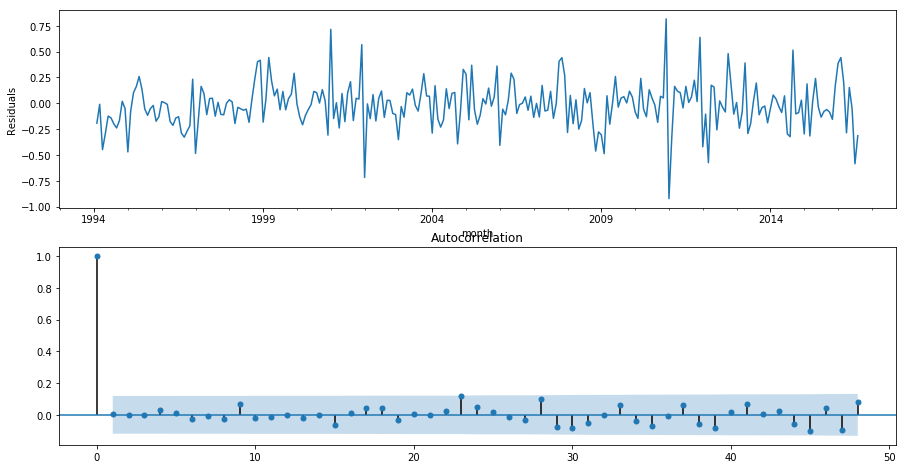

In [136]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values, lags=48, ax=ax)
plt.show()

In [137]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Критерий Стьюдента: p=0.163682


Полученный критерий Стьюдента говорит о несмещенности остатков.

In [141]:
print("Критерий Дики-Фуллера: p=%.30f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера: p=0.000000000000000000000000000038


Полученный критерий Дики-Фуллера говорит о стационарности остатков.

In [147]:
# вычисление обратного преобразования к преобразованию Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

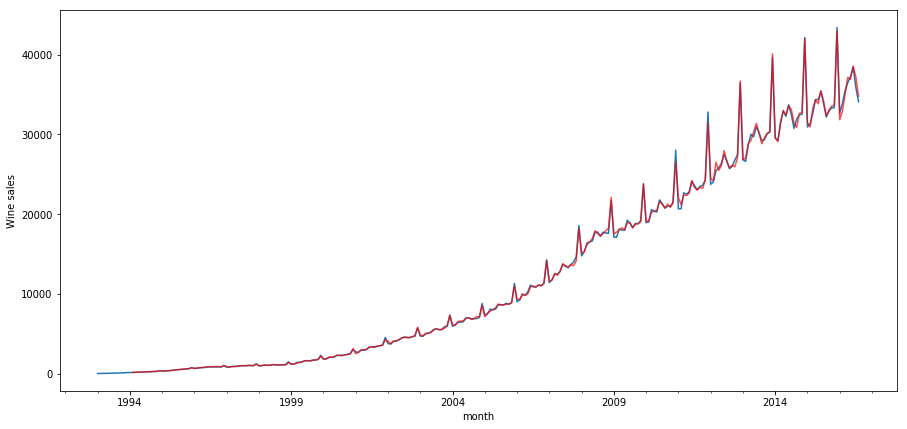

In [152]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r',alpha=0.7)
plt.ylabel('Wine sales')
pylab.show()

### Прогнозирование с помощью финальной модели

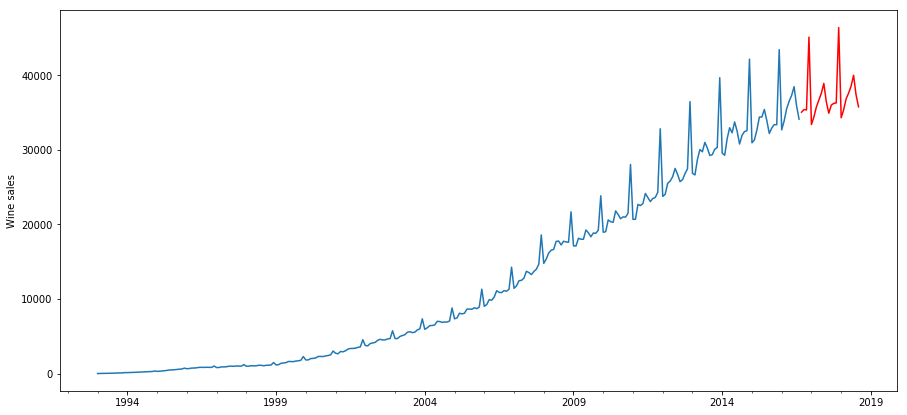

In [166]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()